In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from deluca.envs import PlanarQuadrotor
from deluca.envs.classic._planar_quadrotor import dissipative
from deluca.agents import ILQR
from deluca.agents import ILC
from deluca.agents import IGPC
from deluca.agents._ilqr import rollout
import numpy as np

In [75]:
global_log = []
wind = 0.4
angle = 0.0
wind_func = dissipative
T = 50
ALPHA = 0.2
LR = 0.0015625

In [76]:
env_true, env_sim = PlanarQuadrotor(wind=wind, wind_func=wind_func), PlanarQuadrotor(wind_func=wind_func)
print('-------------- warmup on ilqr ----------------')
ilqr_sim = ILQR()
c, _ = ilqr_sim.train(env_sim, 20)
print(f"Warmup cost is {c}")
global_log += [f"Warmup cost is {c}"]
print('----------- compute zero_cost -----------')
_,_,ZEROCOST = rollout(env_true, ilqr_sim.U, ilqr_sim.k, ilqr_sim.K, ilqr_sim.X)
print('ZEROCOST:' + str(ZEROCOST))
global_log += ['ZEROCOST: ' + str(ZEROCOST)]
print('-------------- ilqr_true ----------------')
ilqr_oracle = ILQR()
c, log = ilqr_true.train(env_true, T, ilqr_sim.U)
global_log += log[5:]
print(global_log)

-------------- warmup on ilqr ----------------
initial cost:374122.0319286693
(iLQR): t = 0, r = 2, c = 3861.070303926925, alpha = 1.1
(iLQR): t = 1, r = 3, c = 219.2560188542071, alpha = 1.2100000000000002
(iLQR): t = 2, r = 4, c = 69.37626506797741, alpha = 1.3310000000000004
(iLQR): t = 3, r = 5, c = 54.80947011412862, alpha = 1.4641000000000006
(iLQR): t = 4, r = 6, c = 52.38077328597999, alpha = 1.6105100000000008
(iLQR): t = 5, r = 7, c = 51.873685827995075, alpha = 1.771561000000001
(iLQR): t = 6, r = 9, c = 51.81845688524295, alpha = 1.7715610000000013
(iLQR): t = 7, r = 12, c = 51.05492850990631, alpha = 1.3310000000000008
(iLQR): t = 8, r = 13, c = 51.01693221768186, alpha = 1.464100000000001
(iLQR): t = 9, r = 15, c = 50.95909855495757, alpha = 1.464100000000001
(iLQR): t = 10, r = 18, c = 50.77553732274074, alpha = 1.1000000000000005
(iLQR): t = 11, r = 19, c = 50.73619066383522, alpha = 1.2100000000000006
(iLQR): t = 12, r = 20, c = 50.72795106368111, alpha = 1.33100000000

In [77]:
### Hyperparameter Search - ILC Alpha
ilc = ILC()
c_min = 1000000000
good_alpha = 1.0
# for alpha in [0.1,0.2,0.5, 0.8, 1.0, 2.0, 5.0, 10.0]:
for alpha in [ALPHA]:
    print(f"Trying alpha {alpha}")
    c, log = ilc.train(env_true, env_sim, T, ilqr_sim.U, ilqr_sim.k, ilqr_sim.K, ilqr_sim.X, ref_alpha=alpha)
    if alpha == ALPHA: # best alpha
        global_log += log
    if c < c_min:
        c_min = c
        good_alpha = alpha
        print(f"Better Min Changing alpha to {good_alpha}")
env_true.close(), env_sim.close()

Trying alpha 0.2
initial cost:4706.6442262460405
(iLC): t = 0, r = 3, c = 4423.988271839007, alpha = 0.2
(iLC): t = 1, r = 8, c = 4347.697618753635, alpha = 0.04787840987383268
(iLC): t = 2, r = 9, c = 4333.600723441942, alpha = 0.05266625086121595
(iLC): t = 3, r = 12, c = 4320.6047664408325, alpha = 0.039568933780027
(iLC): t = 4, r = 13, c = 4312.756833483722, alpha = 0.043525827158029703
(iLC): t = 5, r = 14, c = 4293.606591448347, alpha = 0.04787840987383268
(iLC): t = 6, r = 15, c = 4245.205408953636, alpha = 0.05266625086121595
(iLC): t = 7, r = 16, c = 4150.808815106562, alpha = 0.05793287594733755
(iLC): t = 8, r = 17, c = 3996.775535241415, alpha = 0.0637261635420713
(iLC): t = 9, r = 18, c = 3774.411787622227, alpha = 0.07009877989627844
(iLC): t = 10, r = 19, c = 3482.1317634852658, alpha = 0.07710865788590629
(iLC): t = 11, r = 20, c = 3127.076126724677, alpha = 0.08481952367449692
(iLC): t = 12, r = 21, c = 2724.8546383058883, alpha = 0.09330147604194662
(iLC): t = 13, r 

(None, None)

In [81]:
### Hyperparameter Search - IGPC Alpha
igpc = IGPC()
U = ilqr_sim.U
c_min = 1000000000
good_alpha = 100000
good_lr = 10000
# for alpha in [0.5, 1.0]:
#     for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
# for alpha in [0.25,0.5,0.75,1.0]:
# for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
for alpha in [0.05]:
    for lr in [0.004]:
        print(f"Trying pair {alpha},{lr}")
        c, log = igpc.train(env_true, env_sim, T, U, ilqr_sim.k, ilqr_sim.K, ilqr_sim.X, lr=lr, ref_alpha=alpha)
        # _,_,_,_,c = Eastman_closed(env_true, env_sim, U, 10, k, K, X, lr=lr, ref_alpha=alpha)
        if alpha == 0.05 and lr == 0.004: # best alpha/lr
            global_log += log
        if c < c_min:
            c_min = c
            good_alpha = alpha
            good_lr = lr
            print(f"Better Min Changing alpha,lr to {good_alpha},{lr}")
print('good_alpha:' + str(good_alpha))
print('good_lr:' + str(good_lr))
print('c_min:' + str(c_min))

Trying pair 0.05,0.004
initial cost:4706.6442262460405
(iGPC): t = 0, r = 2, c = 4053.6665991866835, alpha = 0.05500000000000001
(iGPC): t = 1, r = 3, c = 3454.3385751175183, alpha = 0.06050000000000001
(iGPC): t = 2, r = 4, c = 2919.683593561743, alpha = 0.06655000000000001
(iGPC): t = 3, r = 5, c = 2468.8892355095404, alpha = 0.07320500000000002
(iGPC): t = 4, r = 6, c = 2131.3081911156096, alpha = 0.08052550000000003
(iGPC): t = 5, r = 7, c = 1942.6893732654141, alpha = 0.08857805000000003
(iGPC): t = 6, r = 8, c = 1925.7327034998466, alpha = 0.09743585500000004
(iGPC): t = 7, r = 11, c = 1735.137521146744, alpha = 0.07320500000000002
(iGPC): t = 8, r = 12, c = 1605.2039803577359, alpha = 0.08052550000000003
(iGPC): t = 9, r = 13, c = 1523.240611483324, alpha = 0.08857805000000003
(iGPC): t = 10, r = 14, c = 1461.5920323699484, alpha = 0.09743585500000004
(iGPC): t = 11, r = 15, c = 1378.6243186733102, alpha = 0.10717944050000006
(iGPC): t = 12, r = 16, c = 1237.4068475855988, alpha

Warmup cost is 50.72491395606574
ZEROCOST: 4706.6442262460405
(iLQR): t = 5, r = 7, c = 4487.433523869789, alpha = 1.771561000000001
(iLQR): t = 6, r = 10, c = 1165.552686626119, alpha = 1.3310000000000006
(iLQR): t = 7, r = 15, c = 636.3884339491773, alpha = 0.3186308177103566
(iLQR): t = 8, r = 16, c = 335.17262312184715, alpha = 0.3504938994813923
(iLQR): t = 9, r = 17, c = 199.4399798783902, alpha = 0.3855432894295316
(iLQR): t = 10, r = 18, c = 138.25124645928835, alpha = 0.4240976183724848
(iLQR): t = 11, r = 19, c = 112.70253858155071, alpha = 0.4665073802097333
(iLQR): t = 12, r = 20, c = 103.04324464564458, alpha = 0.5131581182307067
(iLQR): t = 13, r = 21, c = 99.69698924621326, alpha = 0.5644739300537774
(iLQR): t = 14, r = 22, c = 98.57702669855563, alpha = 0.6209213230591553
(iLQR): t = 15, r = 23, c = 98.18736354515545, alpha = 0.6830134553650709
(iLQR): t = 16, r = 24, c = 98.0430138644696, alpha = 0.751314800901578
(iLQR): t = 17, r = 25, c = 97.9885675373576, alpha = 0

<Figure size 432x288 with 0 Axes>

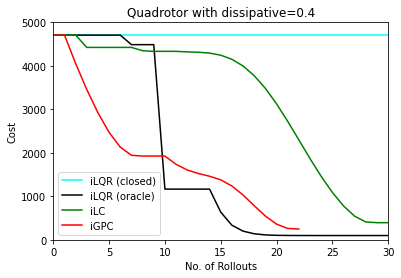

In [82]:
# Plot alpha = 0.5 experiment

import matplotlib.pyplot as plt
from pprint import pprint
import re
import sys

global_log_alpha_half = ''
for s in global_log:
    global_log_alpha_half += s + '\n'
print(global_log_alpha_half)

def postprocess(a):
    rs, vs = a
    newrs, newvs = [], []
    ref = 0
    for (i, (r, v)) in enumerate(zip(rs, vs)):
        r = int(r)
        if i == len(rs) - 1:
            newrs += [r]
            newvs += [v]
        else:
            next_r = int(rs[i + 1])
            newrs += list(range(r, next_r))
            newvs += [v for _ in range(r, next_r)]
    return newrs, newvs


### This file is to plot the results of the first experiment on Quadrotor

all_results = {}
for param in [-10.0]:
    txt = global_log_alpha_half
    pattern = f"ZEROCOST: ([0-9.]*)"
    results = re.findall(pattern, txt)
    zerocost = float(results[0])

    pattern = f"(.*): t = [0-9]*, r = ([0-9]*), c = ([0-9.]*)"
    results = list(zip(*re.findall(pattern, txt)))
    if len(results) > 0:
        results = results[0], list(map(float, results[1])), list(map(float, results[2]))
    all_keys = list(set(results[0]))
    
    results_dict = {}
    for k in all_keys:
        indices = [i for i, x in enumerate(results[0]) if x == k]
        results_dict[k] = [
            [0] + [results[1][i] for i in indices],
            [zerocost] + [results[2][i] for i in indices],
        ]
    all_results[param] = results_dict

print(all_results)

#print(postprocess(all_results[-10.0]['Eastman (closed+de+lr+0.01)']))
plt.figure()
fig, ax = plt.subplots(1, 1)
x_dict = {-10.0: 15}
for (i, w) in enumerate([-10.0]):
    a = ax
    px, py = list(range(0, 100)), [
        all_results[w]["(iLQR)"][1][0] for _ in range(0, 100)
    ]
    a.plot(px, py, label="iLQR (closed)", color="aqua")
    px, py = postprocess(all_results[w]["(iLQR)"])
    a.plot(px, py, label="iLQR (oracle)", color="black")
    px, py = postprocess(all_results[w]["(iLC)"])
    a.plot(px, py, label="iLC", color="green")
    px, py = postprocess(all_results[w]["(iGPC)"])
    a.plot(px, py, label="iGPC", color="red")
    a.set_ylim(0, 5000)
    a.set_xlim(0, 30)
    a.set_xlabel("No. of Rollouts")
    a.set_ylabel("Cost")
    a.set_title(f"Quadrotor with dissipative={wind}")
    # #plt.yscale('log')
    a.legend(loc="best")
plt.show()
